<a href="https://colab.research.google.com/github/brentsnyder/blog/blob/fastpages-automated-setup/2021_08_24_Exploring_Board_Game_Popularity.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# "Exploring Board Game Popularity"
> "Which Board games are most popular and how predictive is the CatBoost algorithm on a hold out validation set?"

- toc: false
- branch: master
- badges: false
- comments: true
- categories: [python, modeling]
- image: images/board-game-image.png
- hide: false
- search_exclude: true

For those of you who are not familiar with SLICED it is one of the fastest growing data science competitions. I've benefied from competitors sharing their work and working through the datasets. Another benefit is that the datasets are provided and cleaned by the organizers so aspiring data scientists can learn modeling without searching for datasets. 

The dataset I will be analyzing in this post is from [Season 1 Episode 1 of SLICED](https://www.kaggle.com/c/sliced-s01e01/data?select=train.csv), hosted on Kaggle.

This solution will provide a top 5 result on the private leaderboard, but I encourage you to build upon the result and do additional feature engineering and CatBoost hyperparameter tuning.  Let's get started.

### Import libraries and data

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error
from tqdm.notebook import tqdm
from sklearn.ensemble import RandomForestRegressor

pal = sns.color_palette()

In [6]:
!pip install catboost
from catboost import CatBoostRegressor

In [9]:
df_train = pd.read_csv("/content/drive/MyDrive/ds_projects/sliced_s01_e01/train.csv")
df_test = pd.read_csv("/content/drive/MyDrive/ds_projects/sliced_s01_e01/test.csv")

The first thing I notice about the data is that the train and test data is small. 3499 rows in the train and 1500 in the test.

In [10]:
df_train.shape, df_test.shape

((3499, 26), (1500, 25))

A quick look at the data shows that missing values will not be an issue. There are 12 categories of board games that are spread across columns. We'll need to stack them later.

In [42]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3499 entries, 0 to 3498
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   game_id      3499 non-null   int64  
 1   names        3499 non-null   object 
 2   min_players  3499 non-null   int64  
 3   max_players  3499 non-null   int64  
 4   avg_time     3499 non-null   int64  
 5   min_time     3499 non-null   int64  
 6   max_time     3499 non-null   int64  
 7   year         3499 non-null   int64  
 8   geek_rating  3499 non-null   float64
 9   num_votes    3499 non-null   int64  
 10  age          3499 non-null   int64  
 11  mechanic     3499 non-null   object 
 12  owned        3499 non-null   int64  
 13  category1    3499 non-null   object 
 14  category2    2888 non-null   object 
 15  category3    1726 non-null   object 
 16  category4    863 non-null    object 
 17  category5    401 non-null    object 
 18  category6    136 non-null    object 
 19  catego

Geek rating is the variable that we are tasked with predicting. I'm surprised that the scale is tighter. They must have truncated the data. Mean rating is 6.09 and the min is 5.64 and max is 8.50. 

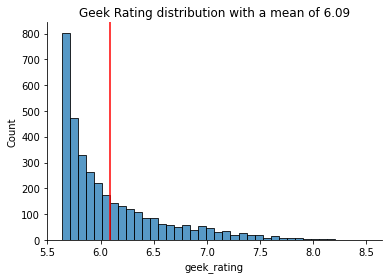

In [38]:
mean_rating = df_train['geek_rating'].mean()

sns.histplot(df_train['geek_rating'])
plt.axvline(mean_rating, color = 'red')
sns.despine()
plt.title(f'Geek Rating distribution with a mean of {round(mean_rating,2)}');

In [40]:
df_train['geek_rating'].describe().to_frame()

,geek_rating
count,3499.000000
mean,6.087625
std,0.482988
min,5.640240
25%,5.726210
50%,5.904700
75%,6.302635
max,8.501630


### Feature engineering numerical features

There are quite a few variables with skewed distributions in the tails. This presents opportunities for transformations.

In [53]:
# set up list of numerical features
num_feats = ['min_players', 'max_players', 'avg_time', 
             'min_time', 'max_time', 'year',
             'num_votes', 'age', 'owned']

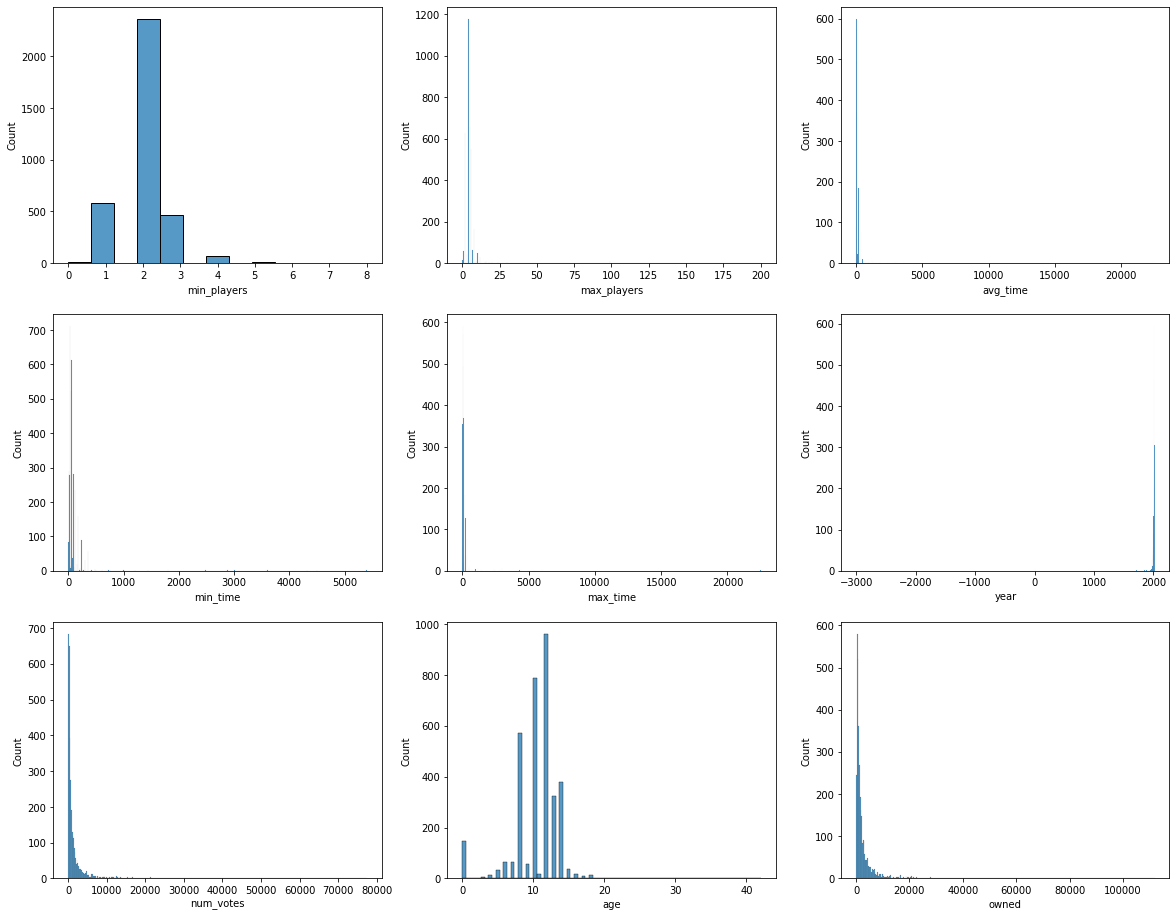

In [54]:
a = len(num_feats)
b = round(len(num_feats) / 3)
c = 1

fig = plt.figure(figsize=(20,50))

for i in num_feats:
  plt.subplot(a,b,c)
  sns.histplot(df_train[i])
  plt.xlabel(i)

  c += 1

Log transforming the Owned and Number Votes variables make them normal which may be useful for modeling.

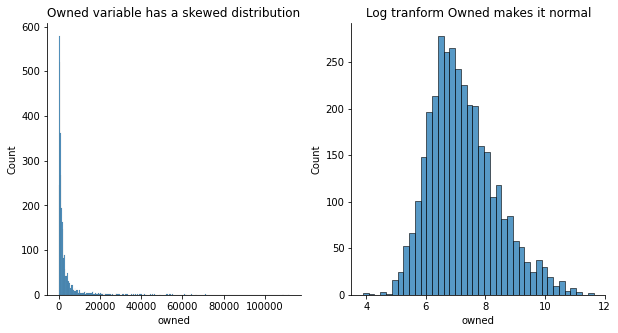

In [43]:
f, axes = plt.subplots(1,2, figsize=[10,5])

sns.histplot(df_train['owned'], ax = axes[0])
sns.histplot(np.log(df_train['owned']), ax = axes[1])
sns.despine()
axes[0].set_title('Owned variable has a skewed distribution')
axes[1].set_title('Log tranform Owned makes it normal');

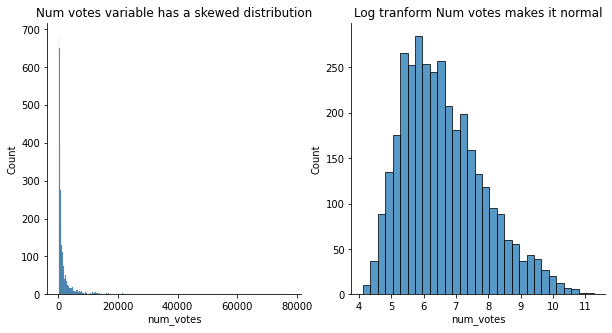

In [44]:
f, axes = plt.subplots(1,2, figsize=[10,5])

sns.histplot(df_train['num_votes'], ax = axes[0])
sns.histplot(np.log(df_train['num_votes']), ax = axes[1])
sns.despine()
axes[0].set_title('Num votes variable has a skewed distribution')
axes[1].set_title('Log tranform Num votes makes it normal');

Correlation plot shows that there are some relationships between predictors. As expected, min, max, and average time are correlated. 

Owned and Number votes are the most correlated with geek rating. With limited feature engineering I am sure we will see those 2 variables being important in our first model's variable importance plots.

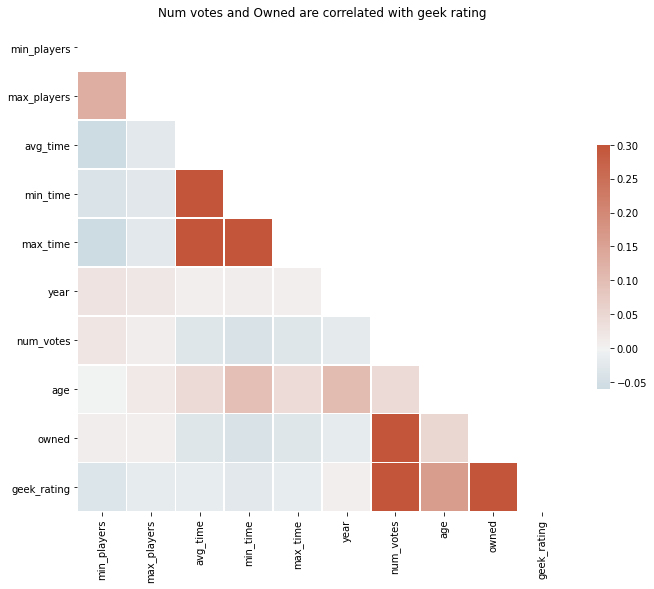

In [57]:
corr = df_train.loc[:, num_feats + ['geek_rating']].corr()

mask = np.triu(np.ones_like(corr, dtype=bool))
# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})

plt.title('Num votes and Owned are correlated with geek rating');

### Feature engineering using the categorical columns

68.8% of games have 1 designer but there are over 1,000 games that have multiple designers.

However, it is not clear from the boxplot that games that have multiple designers have higher ratings. Games that have 4 or 5 designers have slightly higher ratings but it based on a smaller sample size.

In [58]:
# count number of designers
df_train['nbr_designers'] = df_train['designer'].apply(lambda x: x.count(',')+1)
# bucket 3+ designers
df_train['nbr_designers'] = df_train['nbr_designers'].apply(lambda x: 3 if x > 3 else x)
designer_df = df_train.loc[:, ['designer', 'nbr_designers','geek_rating']].reset_index()

In [80]:
df_train['nbr_designers'].value_counts(normalize=True)*100

1    68.762504
2    23.692484
3     7.545013
Name: nbr_designers, dtype: float64

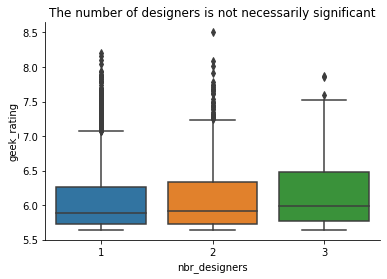

In [85]:
sns.boxplot(x = 'nbr_designers', y = 'geek_rating', data = df_train)
sns.despine()
plt.title('The number of designers is not necessarily significant');

Reiner Knizia has the most games credited at 80. The closest designer (excluding uncredited) is Martin Wallace at 35 games designed. 

In [74]:
# expand list of designers and stack for easy comparison
designer_stack = df_train.loc[:, 'designer'].str.split(', ', expand=True).stack().to_frame().reset_index().loc[:, ['level_0', 0]].rename(columns = {'level_0': 'index', 0:'designer'})
designer = designer_stack.merge(designer_df, left_on='index', right_on='index')

In [86]:
# most prolific solo designers
designer.loc[designer['nbr_designers']==1, :].groupby('designer_x').agg(mean_geek_rating = ('geek_rating', np.mean) , nbr_games = ('geek_rating', len)).reset_index().sort_values(by='nbr_games',ascending=False).reset_index().head(20)

,index,designer_x,mean_geek_rating,nbr_games
0,860,Reiner Knizia,6.075032,80.0
1,0,(Uncredited),6.031453,50.0
2,697,Martin Wallace,6.304218,35.0
3,374,Friedemann Friese,6.197290,27.0
4,1094,none,5.801660,24.0
5,609,Klaus Teuber,6.058212,24.0
6,740,Michael Schacht,6.112761,20.0
7,1052,Uwe Rosenberg,6.764786,19.0
8,920,Rüdiger Dorn,6.372285,17.0
9,209,Corné van Moorsel,5.926044,16.0


Nikki Valens is the most popular designer followed behind is Adam Poots. 

In [88]:
top_solo_designers = designer.loc[designer['nbr_designers']==1, :].groupby('designer_x').agg(mean_geek_rating = ('geek_rating', np.mean) , nbr_games = ('geek_rating', len)).reset_index().sort_values(by='mean_geek_rating',ascending=False).head(20).reset_index()
bottom_solo_designers = designer.loc[designer['nbr_designers']==1, :].groupby('designer_x').agg(mean_geek_rating = ('geek_rating', np.mean) , nbr_games = ('geek_rating', len)).reset_index().sort_values(by='mean_geek_rating',ascending=True).head(20).reset_index()

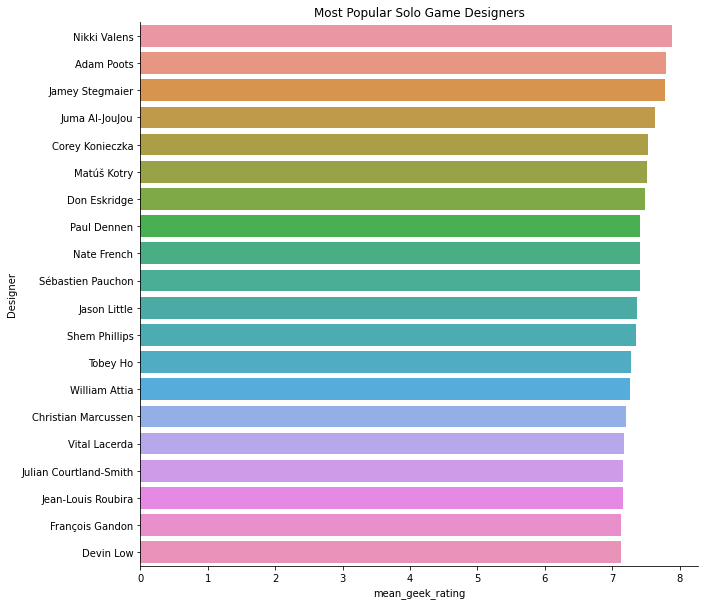

In [92]:
plt.figure(figsize=[10,10])
sns.barplot(y = 'designer_x', x = 'mean_geek_rating', data = top_solo_designers)
sns.despine()
plt.ylabel('Designer')
plt.title('Most Popular Solo Game Designers');

Card Game, Wargame, and Fantasy categories have the most number of games.

In [ ]:
# category columns merge and stack
cat_col_names = [i for i in df_train.columns.values if i.find('cat')==0]

category_stacked = df_train.loc[:, cat_col_names].stack().reset_index().rename(columns = {'level_0':'index', 0:'category'}).loc[:, ['index', 'category']]

category_stacked['category'] = category_stacked.loc[:, 'category'].apply(lambda x: x.strip())

# merge with geek rating and aggregate
geek_rating_by_category = category_stacked.merge(df_train.loc[:, ['geek_rating']].reset_index(), left_on='index', right_on='index')

geek_rating_by_category = geek_rating_by_category.groupby('category').agg(mean_geek_rating = ('geek_rating', np.mean), nbr_games = ('geek_rating',len)).reset_index()

In [ ]:
# most prolific categories
geek_rating_by_category.sort_values('nbr_games', ascending=False).head(20)

,category,mean_geek_rating,nbr_games
14,Card Game,6.049298,969.0
78,Wargame,5.975838,635.0
29,Fantasy,6.172004,535.0
23,Economic,6.309115,395.0
31,Fighting,6.260619,380.0
67,Science Fiction,6.190278,327.0
22,Dice,6.067265,265.0
12,Bluffing,6.112396,229.0
2,Adventure,6.238299,223.0
44,Miniatures,6.205932,223.0


Mature / Adult, Farming, and Environmental are the categories with the highest rated games.

In [ ]:
geek_rating_by_category.sort_values('mean_geek_rating', ascending=False).head(20)

,category,mean_geek_rating,nbr_games
39,Mature / Adult,6.541271,11.0
30,Farming,6.443360,56.0
26,Environmental,6.396710,40.0
59,Post-Napoleonic,6.374407,18.0
35,Industry / Manufacturing,6.368233,90.0
66,Renaissance,6.366714,89.0
18,Civilization,6.356147,115.0
69,Spies/Secret Agents,6.355862,46.0
16,City Building,6.319009,171.0
23,Economic,6.309115,395.0


The lowest rated games are Music, Math, and Game System. There also quite a few war related categores in the bottom 20: American Civil War, Korean War, World War I and II.

In [ ]:
geek_rating_by_category.sort_values('mean_geek_rating', ascending=True).head(20)

,category,mean_geek_rating,nbr_games
48,Music,5.759700,5.0
38,Math,5.807560,8.0
32,Game System,5.820436,9.0
13,Book,5.865290,20.0
4,American Civil War,5.872653,42.0
36,Korean War,5.874700,3.0
61,Print & Play,5.879822,58.0
50,Napoleonic,5.886461,47.0
15,Children's Game,5.890584,105.0
77,Vietnam War,5.915079,12.0


Prepare features for modeling

In [93]:
# log transform
df_train['owned_log'] = np.log(df_train['owned'])
df_test['owned_log'] = np.log(df_test['owned'])

df_train['num_votes_log'] = np.log(df_train['num_votes'])
df_test['num_votes_log'] = np.log(df_test['num_votes'])

In [94]:
# dummy variables for categories
df_test['geek_rating'] = -1

df = pd.concat([df_train, df_test])

cat_col_names = [i for i in df.columns.values if i.find('cat')==0]
df['category_list'] = df[cat_col_names].apply(lambda x: ', '.join(x[x.notnull()]), axis = 1)
category_dummies = df['category_list'].str.get_dummies(sep=', ')

df = pd.concat([df, category_dummies], axis = 1)
df_train = df.loc[df['geek_rating']!=-1,:]
df_test = df.loc[df['geek_rating'] == -1,:]

In [104]:
num_feats = [
               'min_players', 
               'max_players', 
               'avg_time', 
               'min_time',
               'max_time', 
               'year', 
               'num_votes_log', 
               'age',
               'owned_log'
]

target = 'geek_rating'

In [99]:
# fillna for missing category 2
df_train['category2'].fillna('none', inplace=True)
df_test['category2'].fillna('none', inplace=True)

# list cat vars
categorical_variables  = ['category1','category2', 'mechanic', 'designer']

Catboost Regressor for modeling geek rating with the defined predictor variables. I also tested XGBoost and CatBoost performs great on this dataset.

In [105]:
folds = 5
kf = KFold(folds)

df_preds = pd.DataFrame()

for train_idx, test_idx in tqdm(kf.split(df_train), total=folds):
  train_data = df_train.iloc[train_idx]
  test_data = df_train.iloc[test_idx].copy()

  proportion_clf = CatBoostRegressor(cat_features=categorical_variables,
                                           logging_level="Silent",
                                           loss_function="MAE")
        
  proportion_clf.fit(train_data.loc[:, num_feats+categorical_variables], train_data[target])

  test_data['preds'] = pd.DataFrame(proportion_clf.predict(test_data.loc[:, num_feats+categorical_variables]), index=test_data.index)
  df_preds = df_preds.append(test_data)

  0%|          | 0/5 [00:00<?, ?it/s]

The RMSE (root mean squared error) is 0.1713 which translates to a private leaderboard score on Kaggle of 0.16855. This places us in 5th place with minimal feature engineering and hyperparameter tuning.

In [106]:
rmse = np.sqrt(mean_squared_error(df_preds[target], df_preds['preds']))
rmse

0.17132000754051915

Variable importance plots show that number votes and owned are most helpful for the model. Year is another important feature. 

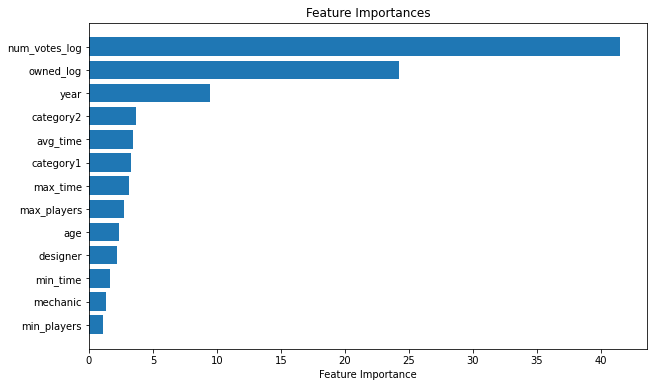

In [107]:
importances = proportion_clf.feature_importances_
idxs = np.argsort(importances)

plt.figure(figsize=(10,6))
plt.title('Feature Importances')
plt.barh(range(len(idxs)), importances[idxs], align='center')
plt.yticks(range(len(idxs)), [train_data.loc[:, num_feats+categorical_variables].columns[i] for i in idxs])
plt.xlabel('Feature Importance')
plt.show()

This proved to be a fun and interesting dataset. In some cases smaller datasets are not as interesting, but this is an exception. In the future I would spend time:

1.   More in-depth data exploration
2.   CatBoost hyperparameter tuning
3.   Explore modeling more categories
4.   Possibly scrape the board game website for more predictors
5.   Learn more about board games and see what new insights I can find in the data 

Thanks for reading and reach out if you want to chat about the analysis.
